In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow

In [6]:
import pycuda.driver as cuda

In [33]:
from cuda_model import histogramModule
from filters import custom_filter, median_filter

In [26]:
# для просмотра картинок
def check_picture(path_to_picture):
  img = cv2.imread(path_to_picture, cv2.IMREAD_GRAYSCALE)
  img = np.hstack([np.zeros((img.shape[0], 1)), img, np.zeros((img.shape[0], 1))])
  img = np.vstack([np.zeros((img.shape[1],)), img, np.zeros((img.shape[1],))])
  cv2_imshow(img)

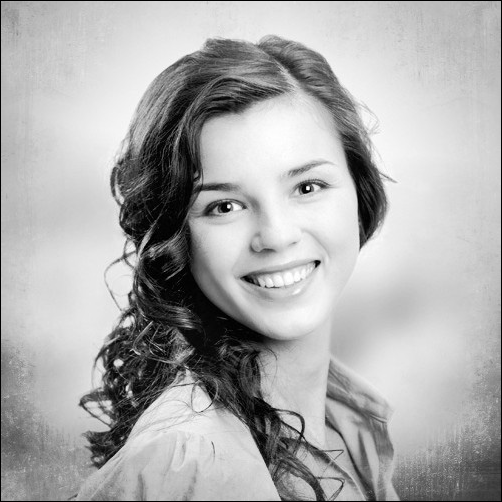

In [27]:
# смотрим на оригинальную картинку
check_picture('/content/lady.jpeg')

In [ ]:
image = np.array(cv2.imread("/content/lady.jpeg"))

filtered_image = median_filter(image)
cv2.imwrite("/content/lady_median.jpeg", filtered_image)

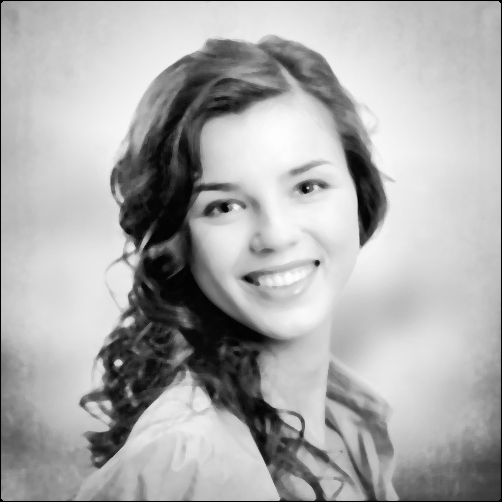

In [28]:
check_picture("/content/lady_median.jpeg")

In [ ]:
template = np.random.rand(5, 5)
filtered_image = custom_filter(image, template)
cv2.imwrite("/content/lady_custom.jpeg", filtered_image)

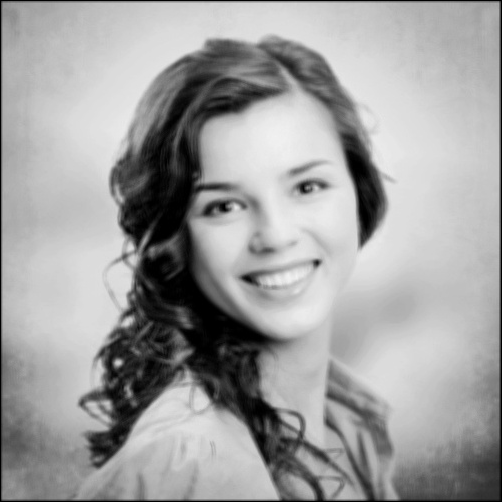

In [34]:
check_picture("/content/lady_custom.jpeg")

# Гистограмма

In [31]:
h_img = cv2.imread("/content/lady.jpeg", 0).astype(np.int32)
d_img = cuda.mem_alloc(h_img.nbytes)
cuda.memcpy_htod(d_img, h_img)
h_img.shape

(500, 500)

In [32]:
rows = h_img.shape[1]
cols = h_img.shape[0]
block_size = 32
block = (block_size, block_size, 1)
grid = ((rows + block_size - 1) // block[0], (cols + block_size - 1) // block[1])

bin_count = 128
h_bins = np.linspace(0, 256, bin_count + 1, dtype=np.int32)
d_bins = cuda.mem_alloc(h_bins.nbytes)
cuda.memcpy_htod(d_bins, h_bins)
h_bins
     

array([  0,   2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,
        26,  28,  30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,
        52,  54,  56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,
        78,  80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 100, 102,
       104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128,
       130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154,
       156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180,
       182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206,
       208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232,
       234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256],
      dtype=int32)

In [35]:
h_hist = np.zeros(bin_count, dtype=np.int32)
d_hist = cuda.mem_alloc(h_hist.nbytes)
cuda.memcpy_htod(d_hist, h_hist)
h_hist

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [39]:
histogram = histogramModule.get_function('histogram')

In [40]:
histogram(
    np.int32(bin_count), 
    d_bins,
    np.int32(h_img.shape[0]), 
    np.int32(h_img.shape[1]), 
    d_img, 
    d_hist, 
    block=block,
    grid=grid
)
cuda.memcpy_dtoh(h_hist, d_hist)

In [41]:
cuda.memcpy_dtoh(h_hist, d_hist)
h_hist

array([ 668, 1012, 1531, 1599, 1504, 1128,  884,  692,  752,  725,  723,
        677,  723,  700,  702,  745,  694,  714,  686,  737,  785,  791,
        749,  757,  754,  736,  721,  774,  750,  728,  858,  845,  868,
        834,  784,  843,  829,  807,  768,  789,  788,  790,  749,  812,
        812,  861,  869,  833,  891,  834,  877,  859,  862,  877,  841,
        858,  823,  885,  892,  888,  853,  874,  897,  887,  930,  999,
       1001, 1024, 1097, 1058, 1078, 1122, 1120, 1118, 1126, 1143, 1128,
       1120, 1048, 1069, 1098, 1006, 1028, 1062, 1103, 1130, 1144, 1286,
       1598, 1890, 2373, 3150, 3927, 4414, 4837, 5071, 4905, 4891, 4800,
       5265, 5592, 5734, 5977, 5953, 5779, 6195, 6162, 5874, 6292, 6340,
       6277, 5691, 5720, 5875, 6198, 6357, 4595, 4552, 4101, 3306, 3156,
       2277, 1891, 1373,  764,  510,  442,   80], dtype=int32)

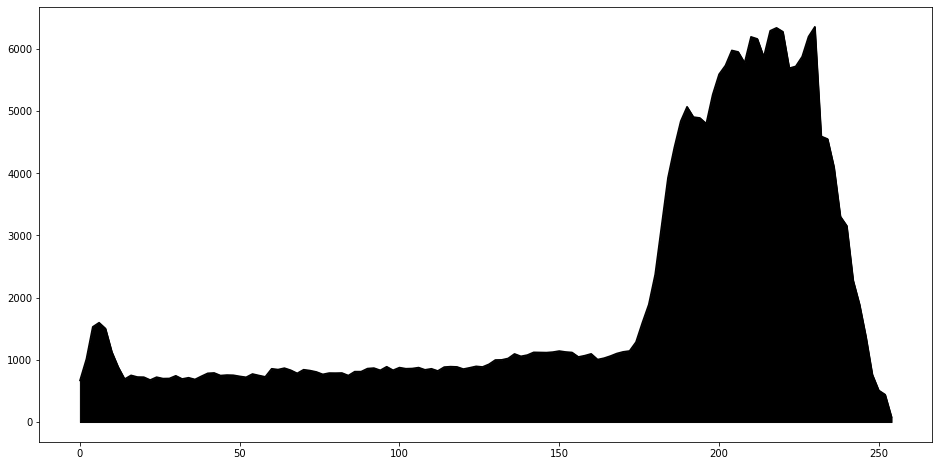

In [42]:
plt.figure(figsize=(16, 8))
plt.plot(h_bins[:-1], h_hist, c='black')
plt.fill_between(h_bins[:-1], h_hist, color='black')